# Keyword transformation

A linear transformation of keywords from SHARP_LOS to SMARP.

Code adapted from https://github.com/mbobra/smarp/blob/master/figures/Figure3.ipynb

In [1]:
import numpy as np
import pandas as pd
from tqdm import trange, tqdm
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression as LR, Lasso
from sklearn.model_selection import train_test_split
import drms

In [2]:
email = 'szymails@gmail.com'
c = drms.Client(debug=False, verbose=False, email=email)

### Find all the NOAA active regions that appear in both the SMARP and SHARP database

In [3]:
# SHARP and SMARP overlap period
t_start = '2010.05.01_00:00:00_TAI'
t_end = '2010.10.28_00:00:00_TAI'

Construct the queries to identify all the active regions during the overlap period that have a NOAA active region number (`NOAA_ARS <> \'MISSING\'`) and more than 10 observations (`N_PATCH1 > 10`).

The SHARP series have a few keywords that define the beginning and end of a HARP's lifetime: `T_FRST1` and `T_LAST1`. The SMARP series has an additional keyword, `T_MID1`. It identifies the mid-point record of each `HARPNUM` or `TARPNUM`. Using the clause `T_MID1=T_REC` or `T_FRST1=T_REC` selectes only one record per TARPNUM. This is appropriate because the keywords `NOAA_ARS` and `NPATCH_1` are constant per `TARPNUM`.

In [4]:
hmi_query_string = 'hmi.sharp_cea_720s[]['+t_start+'-'+t_end+'][? (T_FRST1=T_REC) AND (NOAA_ARS <> \'MISSING\') AND (N_PATCH1 > 10) ?]'
khmi = c.query(hmi_query_string, key='NOAA_ARS,HARPNUM')

mdi_query_string = 'su_mbobra.smarp_cea_96m[]['+t_start+'-'+t_end+'][? (T_MID1=T_REC) AND (NOAA_ARS <> \'MISSING\') AND (N_PATCH1 > 10) ?]'
kmdi = c.query(mdi_query_string, key='NOAA_ARS,TARPNUM')

# Drop all rows that have a missing NOAA active region number
khmi = khmi.drop(khmi.index[khmi['NOAA_ARS'] == 'MISSING']);
kmdi = kmdi.drop(kmdi.index[kmdi['NOAA_ARS'] == 'MISSING']);

keys = pd.merge(khmi, kmdi, on='NOAA_ARS')
keys

,NOAA_ARS,HARPNUM,TARPNUM
0,11067,1,13395
1,11064,2,13394
2,11069,8,13404
3,11066,10,13400
4,11063,11,13401
5,11068,12,13402
6,11070,14,13410
7,11072,26,13433
8,11073,38,13451
9,11075,40,13454


### Plot all of the spaceweather keyword values for these common active regions

Query all the spaceweather keyword metadata for the common NOAA active regions identified above. Select all records where:
1. The same `T_REC` appears in both the SMARP and SHARP data,
2. The HARP or TARP is within 70 degrees of central meridian, and
3. The data are of good quality (`(QUALITY<262144)` for SMARP and `(QUALITY<65536)` for SHARP).

Note that here we are querying the keyword-only series su_mbobra.sharp_loskeys_720s.

In [5]:
list_of_dataframes = []

for i in range(len(keys)):
    HARPNUM = str(keys['HARPNUM'][i])
    TARPNUM = str(keys['TARPNUM'][i])

    print('Gathering data for HARPNUM', HARPNUM, 'and TARPNUM', TARPNUM)

    # query all records for this harpnum
    hmi_query_string = 'su_mbobra.sharp_loskeys_720s['+HARPNUM+'][][? (QUALITY<65536) ?]'
    khmilos = c.query(hmi_query_string, key='T_REC,HARPNUM,USFLUX,MEANGBZ,R_VALUE,INSTRUME')

    hmi_query_string = 'hmi.sharp_cea_720s['+HARPNUM+'][][? (QUALITY<65536) ?]'
    khmivec = c.query(hmi_query_string, key='T_REC,NOAA_ARS,CRVAL1,CRLN_OBS,TELESCOP,USFLUX,MEANGBZ,R_VALUE')

    # query all records for this tarpnum
    mdi_query_string = 'su_mbobra.smarp_cea_96m['+TARPNUM+'][][? (QUALITY<262144) ?]'
    kmdi = c.query(mdi_query_string, key='T_REC,TARPNUM,NOAA_ARS,CRVAL1,CRLN_OBS,USFLUX,MEANGBZ,R_VALUE,TELESCOP')

    # merge SHARP and SMARP dataframes and only keep records with common T_RECs
    df1 = pd.merge(khmilos, khmivec, on='T_REC', suffixes=('_LOS', '_VEC'))
    df = pd.merge(df1, kmdi, on='T_REC', suffixes=('_HMI', '_MDI'))

    # drop rows with nans
    df = pd.DataFrame.dropna(df).reset_index(drop=True)

    # calculate the stonyhurst longitude: CRVAL1 - CRLN_OBS
    # and add it as another column
    stonyhurst_longitude = pd.Series(df['CRVAL1_HMI'] - df['CRLN_OBS_HMI'], name='stonyhurst_longitude')
    df = df.assign(stonyhurst_longitude=stonyhurst_longitude.values)

    # drop rows with a stonyhurst_longitude value greater than 70
    df = df[stonyhurst_longitude.abs() < 70].reset_index(drop=True)

    # concatenate with other active region metadata keys
    list_of_dataframes.append(df)

    print('--- Merged ---')

Gathering data for HARPNUM 1 and TARPNUM 13395
--- Merged ---
Gathering data for HARPNUM 2 and TARPNUM 13394
--- Merged ---
Gathering data for HARPNUM 8 and TARPNUM 13404
--- Merged ---
Gathering data for HARPNUM 10 and TARPNUM 13400
--- Merged ---
Gathering data for HARPNUM 11 and TARPNUM 13401
--- Merged ---
Gathering data for HARPNUM 12 and TARPNUM 13402
--- Merged ---
Gathering data for HARPNUM 14 and TARPNUM 13410
--- Merged ---
Gathering data for HARPNUM 26 and TARPNUM 13433
--- Merged ---
Gathering data for HARPNUM 38 and TARPNUM 13451
--- Merged ---
Gathering data for HARPNUM 40 and TARPNUM 13454
--- Merged ---
Gathering data for HARPNUM 41 and TARPNUM 13453
--- Merged ---
Gathering data for HARPNUM 43 and TARPNUM 13456
--- Merged ---
Gathering data for HARPNUM 46 and TARPNUM 13467
--- Merged ---
Gathering data for HARPNUM 49 and TARPNUM 13468
--- Merged ---
Gathering data for HARPNUM 51 and TARPNUM 13472
--- Merged ---
Gathering data for HARPNUM 54 and TARPNUM 13474
--- Merged

In [6]:
df2 = pd.concat(list_of_dataframes).reset_index()
Xm = df2[['MEANGBZ', 'USFLUX', 'R_VALUE']].to_numpy()
Xh = df2[['MEANGBZ_LOS', 'USFLUX_LOS', 'R_VALUE_LOS']].to_numpy()

In [7]:
# Save for future use
df2.to_csv('overlap_keywords.csv', index=False)
df2 = pd.read_csv('overlap_keywords.csv')

/home/zeyusun/.conda/envs/arnet/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.86334715036426e+45, tolerance: 1.9767883628398478e+43
  model = cd_fast.enet_coordinate_descent(


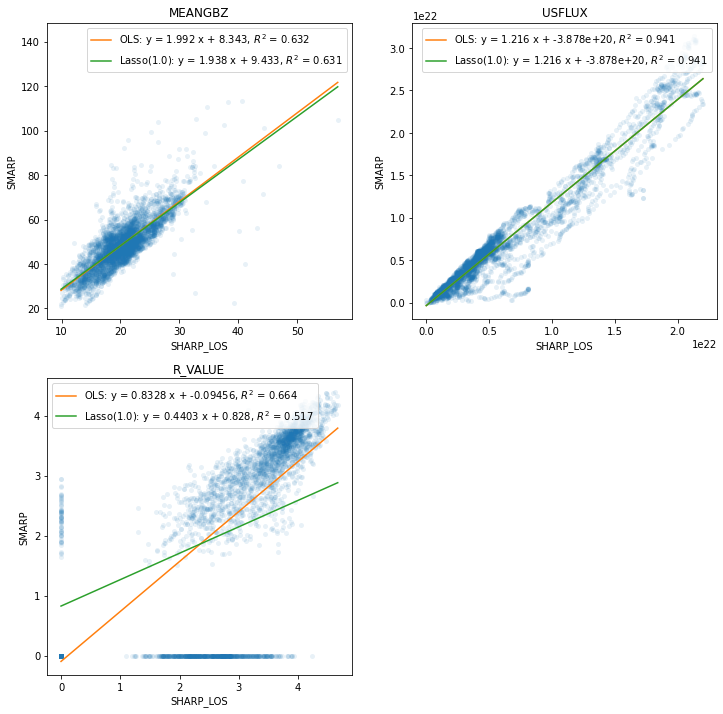

{'MEANGBZ': {'coef': 1.9920261748674042, 'intercept': 8.342889969768606},
 'USFLUX': {'coef': 1.216160520290385, 'intercept': -3.8777994451166115e+20},
 'R_VALUE': {'coef': 0.8327836641793915, 'intercept': -0.0945601961295528}}

In [8]:
keywords = ['MEANGBZ', 'USFLUX', 'R_VALUE']
alpha = 1
params = {}

plt.figure(figsize=(12,12))

for i in range(3):
    x, y = Xh[:,[i]], Xm[:,i]
    X = x.reshape(-1,1)
    lr = LR().fit(X, y)
    lasso = Lasso(alpha=alpha).fit(X, y)

    params[keywords[i]] = {
        'coef': lr.coef_.item(),
        'intercept': lr.intercept_,
    }

    plt.subplot(2,2,i+1)
    plt.plot(x, y, linestyle='', marker='o', markersize=5, markeredgecolor="None", alpha=0.1)

    xlim = np.array([X.min(), X.max()])
    lr_label = 'OLS: y = {:.4} x + {:.4}, $R^2$ = {:.3f}'.format(
        lr.coef_.item(),
        lr.intercept_,
        lr.score(X, y))
    plt.plot(xlim, lr.predict(xlim.reshape(-1, 1)), 'C1', label=lr_label)

    lasso_label = 'Lasso({:.1f}): y = {:.4} x + {:.4}, $R^2$ = {:.3f}'.format(
        alpha,
        lasso.coef_.item(),
        lasso.intercept_,
        lasso.score(X, y))
    plt.plot(xlim, lasso.predict(xlim.reshape(-1, 1)), 'C2', label=lasso_label)

    plt.xlabel('SHARP_LOS')
    plt.ylabel('SMARP')
    plt.title(keywords[i])
    plt.legend()
plt.savefig('outputs/linear_fit.png')
plt.show()
np.save('datasets/sharp2smarp.npy', params)
params

### Evaluate the linear fit on more SMARP and SHARP

In [9]:
def draw_pairplot():
    import seaborn as sns
    sharp2smarp = np.load('datasets/sharp2smarp.npy', allow_pickle=True).item()
    df_smarp = pd.read_csv('datasets/smarp/train.csv').sample(frac=0.01)
    df_sharp = pd.read_csv('datasets/sharp/train.csv').sample(frac=0.01)
    df_trans = df_sharp.copy()

    keys = ['R_VALUE', 'MEANGBZ', 'USFLUX']
    for k in keys:
        v = sharp2smarp[k]
        df_trans[k] = df_sharp[k] * v['coef'] + v['intercept']

    df = pd.concat((df_smarp, df_sharp, df_trans)).reset_index(drop=True)
    df = df[keys]
    df = df.assign(dataset=['SMARP'] * len(df_smarp) +
                           ['SHARP_LOS'] * len(df_sharp) +
                           ['SHARP_LOS_trans'] * len(df_trans))
    sns.pairplot(df, hue='dataset', corner=True,
                 kind='kde', # both diag and off-diag
                 #diag_kind = 'kde',
                 diag_kws = {'common_norm': False}, # kdeplot(univariate)
                 plot_kws = {'common_norm': False, 'levels': 5}, # kdeplot(bivariate)
    )
    plt.savefig('outputs/pairplot.png')
    plt.show()

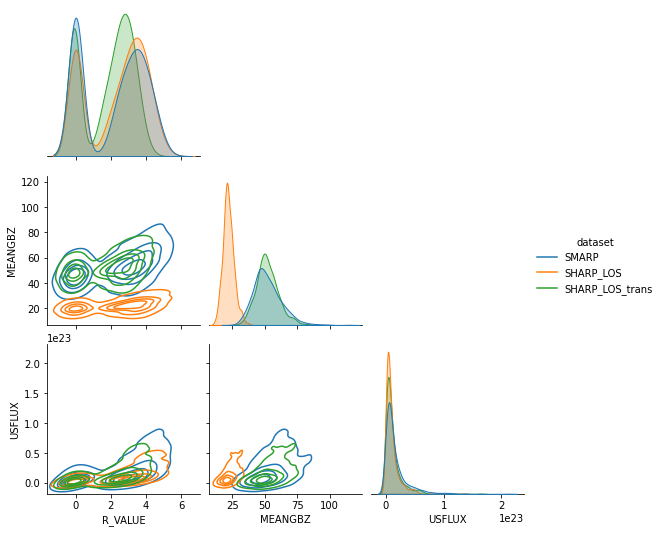

In [10]:
draw_pairplot()

## Multivariate linear regression

In [11]:
from multiprocess import Pool
from sklearn.linear_model import lasso_path
from itertools import cycle
import seaborn as sns

In [12]:
phy_keys = ['USFLUX', 'MEANGBZ', 'R_VALUE']
wcs_keys = ['CRVAL1', 'CRVAL2', 'CRLN_OBS', 'CRLT_OBS', 'CRPIX1', 'CRPIX2']

def get_df(i):
    HARPNUM = str(keys['HARPNUM'][i])
    TARPNUM = str(keys['TARPNUM'][i])

    # query all records for this harpnum
    hmi_query_string = 'su_mbobra.sharp_loskeys_720s['+HARPNUM+'][][? (QUALITY<65536) ?]'
    khmilos = c.query(hmi_query_string, key=['T_REC', 'HARPNUM'] + phy_keys)

    hmi_query_string = 'hmi.sharp_cea_720s['+HARPNUM+'][][? (QUALITY<65536) ?]'
    khmivec = c.query(hmi_query_string, key=['T_REC', 'NOAA_ARS'] + wcs_keys + phy_keys)

    # query all records for this tarpnum
    mdi_query_string = 'su_mbobra.smarp_cea_96m['+TARPNUM+'][][? (QUALITY<262144) ?]'
    kmdi = c.query(mdi_query_string, key=['T_REC', 'TARPNUM'] + wcs_keys + phy_keys)

    # merge SHARP and SMARP dataframes and only keep records with common T_RECs
    df_hmi = pd.merge(khmilos, khmivec, on='T_REC', suffixes=('_LOS', '_VEC'))
    df = pd.merge(df_hmi, kmdi, on='T_REC', suffixes=('_HMI', '_MDI'))

    # drop rows with nans
    df = pd.DataFrame.dropna(df).reset_index(drop=True)

    # calculate the stonyhurst longitude (CRVAL1 - CRLN_OBS) and latitude
    df['LON_HMI'] = df['CRVAL1_HMI'] - df['CRLN_OBS_HMI']
    df['LAT_HMI'] = df['CRVAL2_HMI'] - df['CRLT_OBS_HMI']
    df['LON_MDI'] = df['CRVAL1_MDI'] - df['CRLN_OBS_MDI']
    df['LAT_MDI'] = df['CRVAL2_MDI'] - df['CRLT_OBS_MDI']

    # drop rows with a stonyhurst_longitude value greater than 70
    df = df[df['LON_HMI'].abs() < 70].reset_index(drop=True)
    return df

In [13]:
with Pool(8) as pool:
    list_of_dataframes = pool.map(get_df, range(len(keys)))
df = pd.concat(list_of_dataframes).reset_index(drop=True)

In [14]:
# Difference between the relative locations of patch centers wrt HMI and MDI
# SDO/HMI is geosynchronous so the its measurement of the relative location is stonyhurst coordinates
print((df['LON_HMI'] - df['LON_MDI']).abs().max())
print((df['LAT_HMI'] - df['LAT_MDI']).abs().max())

7.804856999999998
4.011614999999999


In [15]:
# Location relative to the stonyhurst coord sys origin
# But we should choose the solar disk center?
df['LON_ABS'] = df['LON_HMI'].abs()
df['LAT_ABS'] = df['LAT_HMI'].abs()
df['LON_ABS_MDI'] = df['LON_MDI'].abs()
df['LAT_ABS_MDI'] = df['LAT_MDI'].abs()

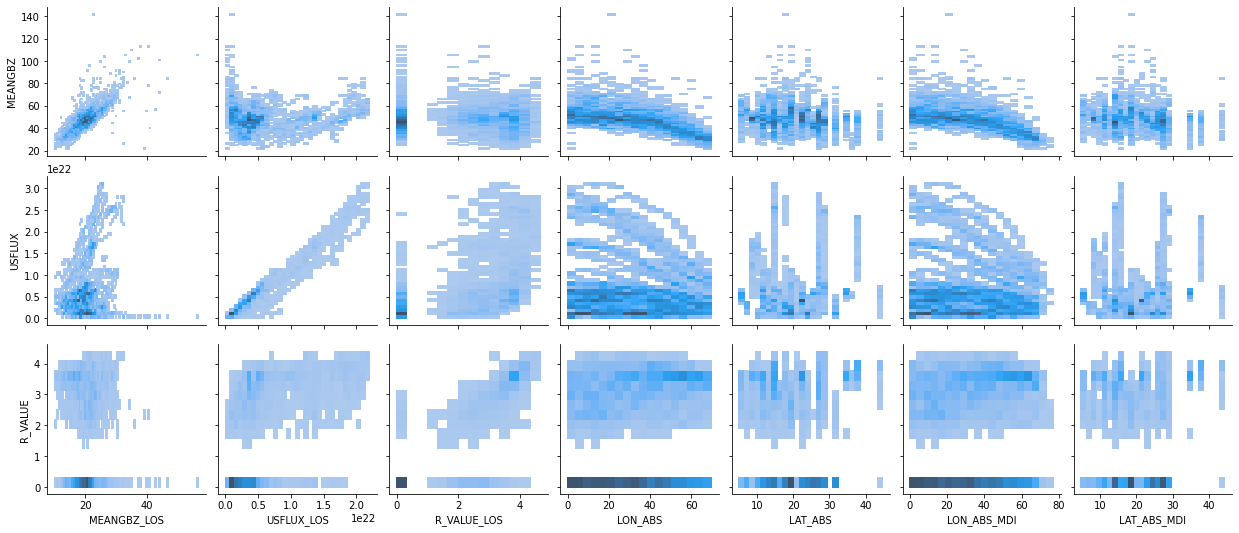

In [16]:
targets = ['MEANGBZ', 'USFLUX', 'R_VALUE']
features = ['MEANGBZ_LOS', 'USFLUX_LOS', 'R_VALUE_LOS', 'LON_ABS', 'LAT_ABS', 'LON_ABS_MDI', 'LAT_ABS_MDI']

# plt.figure(figsize=(12,12))
# sns.pairplot(df[features],
#              #vars=features,
#              kind='hist')
# plt.show()

sns.pairplot(df,
             x_vars=features,
             y_vars=targets,
             kind='hist'
)
plt.show()

MEANGBZ
{'coef': array([ 1.96708489e+00, -4.04393117e-22,  9.81864666e-01,  8.15664250e-03,
        4.04747549e-01, -5.80139481e-02, -4.22022261e-01]), 'coef_normalized': array([ 555.05660342, -143.38821126,  102.62101322,   10.34556737,
        221.50475106,  -74.24377529, -227.67243937]), 'intercept': 10.913393128029767}
USFLUX
{'coef': array([ 4.47755845e+19,  1.21242624e+00,  5.53999304e+19,  2.79800370e+19,
       -7.86627456e+20, -5.33924597e+19,  7.54761310e+20]), 'coef_normalized': array([ 1.26344236e+22,  4.29897599e+23,  5.79020428e+21,  3.54887882e+22,
       -4.30494810e+23, -6.83293917e+22,  4.07178399e+23]), 'intercept': 2.378456762354164e+20}
R_VALUE
{'coef': array([-1.16644951e-02,  4.00038712e-23,  7.75457597e-01, -1.34227344e-02,
       -7.21329633e-02,  9.13323678e-03,  6.78898634e-02]), 'coef_normalized': array([ -3.29139585,  14.18442423,  81.04807831, -17.02487299,
       -39.47595024,  11.68832672,  36.62520259]), 'intercept': 0.2654960872551746}


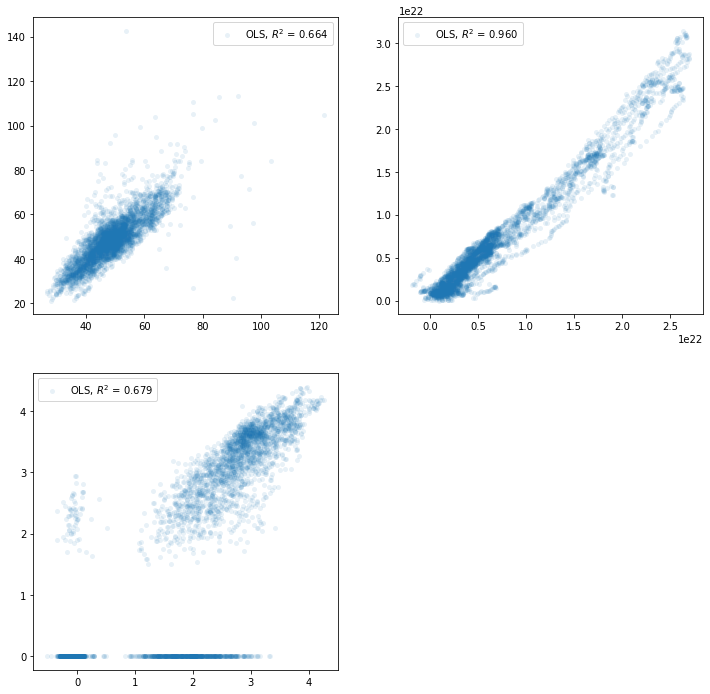

In [17]:
params = {}
plt.figure(figsize=(12,12))
for i, target in enumerate(targets):
    X = df[features].to_numpy()
    X_offset = X.mean(0)
    X_scale = np.linalg.norm(X - X_offset, axis=0)
    y = df[target].to_numpy()

    lr = LR(normalize=True) # normalize seems to make a difference
    lr.fit(X, y)
    params[target] = {
        'coef': lr.coef_,
        'coef_normalized': lr.coef_ * X_scale,
        'intercept': lr.intercept_,
    }
    print(target)
    print(params[target])

    plt.subplot(2,2,i+1)
    y_pred = lr.predict(X)
    plt.plot(y_pred, y, marker='o', linestyle='', markersize=5, markeredgecolor="None", alpha=0.1,
             label='OLS, $R^2$ = {:.3f}'.format(lr.score(X, y)))
    plt.legend()

#plt.savefig('outputs/linear_fit.png')
plt.show()
#np.save('datasets/sharp2smarp.npy', params)

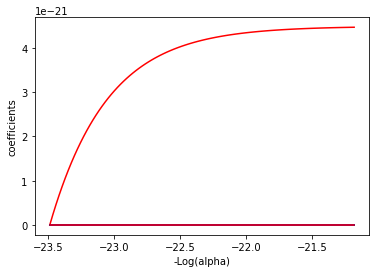

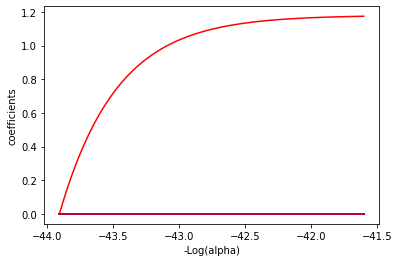

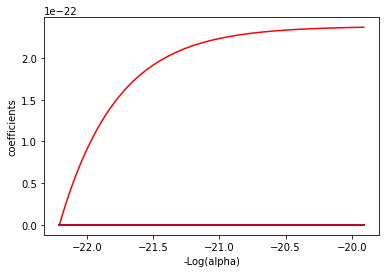

In [18]:
alpha = 1
for i, target in enumerate(targets):
    X = df[features].to_numpy()
    y = df[target].to_numpy()
    #X_offset = X.mean(0)
    #X_scale = np.linalg.norm(X - X_offset, axis=0)

#    lasso = Lasso(alpha=alpha).fit(X, y)

    eps = 5e-3
    alphas_lasso, coefs_lasso, _ = lasso_path(X, y, eps=eps, fit_intercept=False, normalize=True)
    neg_log_alphas_lasso = -np.log10(alphas_lasso)
    colors = cycle(['b', 'r', 'g', 'c', 'k'])
    neg_log_alphas_lasso = -np.log10(alphas_lasso)
    #neg_log_alphas_enet = -np.log10(alphas_enet)

    plt.figure()
    for coef, c in zip(coefs_lasso, colors):
        l1 = plt.plot(neg_log_alphas_lasso, coef, c=c)

    plt.xlabel('-Log(alpha)')
    plt.ylabel('coefficients')
    #plt.title('Lasso and Elastic-Net Paths')
    #plt.legend((l1[-1], l2[-1]), ('Lasso', 'Elastic-Net'), loc='lower left')
    plt.axis('tight')

.

/home/zeyusun/.conda/envs/arnet/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 3 iterations, alpha=1.882e+09, previous alpha=3.869e+02, with an active set of 2 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


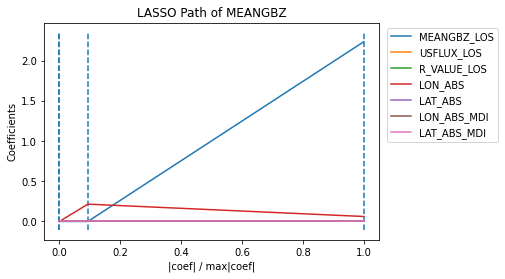

.

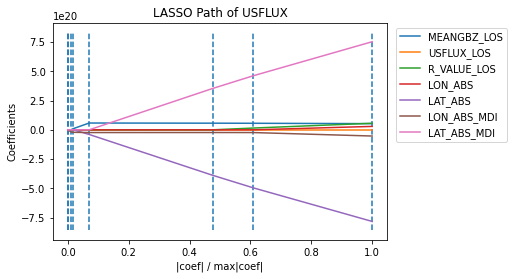

.

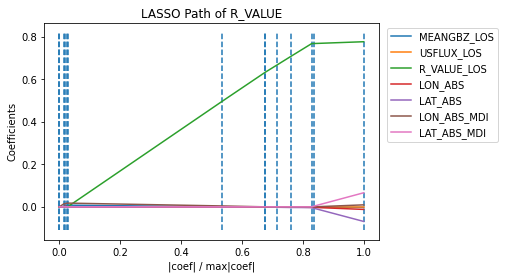

In [19]:
from sklearn import linear_model

X = df[features].to_numpy()
for i, target in enumerate(targets):
    y = df[target].to_numpy()
    alphas, _, coefs = linear_model.lars_path(X, y, method='lasso', verbose=True)

    xx = np.sum(np.abs(coefs.T), axis=1)
    xx /= xx[-1]

    for i, feature in enumerate(features):
        plt.plot(xx, coefs[i], label=feature)
    #plt.plot(xx, coefs.T)
    ymin, ymax = plt.ylim()
    plt.vlines(xx, ymin, ymax, linestyle='dashed')
    plt.xlabel('|coef| / max|coef|')
    plt.ylabel('Coefficients')
    plt.title(f'LASSO Path of {target}')
    plt.axis('tight')
    plt.legend(loc='upper left', bbox_to_anchor=(1.01, 1))
    plt.show()